In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
black_mirror_key = 'tt2085059'

In [3]:
def get_episodes(tv_show_key, seasons):
    url = "http://www.imdb.com/title/{tv_show_key}/episodes?season={season}"
    episodes = []
    for season in range(seasons):
        r = requests.get(url.format(tv_show_key=tv_show_key, season=season+1))
        soup = BeautifulSoup(r.text, "html5lib")
        for episode_idx, episode_titleobject in enumerate(soup.find("div", class_='eplist').find_all('strong')):
            episode_ahref = episode_titleobject.find('a')
            episode_url = episode_ahref.attrs['href']
            episode = {}
            episode['name'] = episode_ahref.text
            episode['id'] = episode_url.split('/')[2]
            episode['number'] = episode_idx+1
            episode['season'] = season+1
            episodes.append(episode)
    return pd.DataFrame(episodes).set_index('id')

In [4]:
def get_votes_info(eid):
    ratings_url = 'http://www.imdb.com/title/{episode_id}/ratings'.format(episode_id=eid)
    r = requests.get(ratings_url)
    soup = BeautifulSoup(r.text, "html5lib")
    table_results = soup.find('div', class_='title-ratings-sub-page').findChildren('table', recursive=False)[0]
    vote_info = {}
    for row_number, row in enumerate(table_results.find_all('tr')[1:]):
        cells = row.find_all('td')
        votes = int(cells[2].text.strip().replace(',',''))
        mark = 10-row_number
        vote_info['votes_'+'%02d' % mark] = votes
    vote_info['imbd_rate'] = float(soup.find('div', class_="ratings-imdb-rating").text.strip())
    separate_table = soup.find('div', class_='title-ratings-sub-page').findChildren('table', recursive=False)[1]
    vote_info['imbd_male_rate'] = float(separate_table.find_all('tr')[2].find_all('td')[1].find('div', class_='bigcell').text)
    vote_info['imbd_female_rate'] = float(separate_table.find_all('tr')[3].find_all('td')[1].find('div', class_='bigcell').text)
    vote_info['id'] = eid
    return vote_info

In [5]:
episodes = get_episodes(black_mirror_key, seasons=4)
votes_info = []
for eid in episodes.index:
    votes_info.append(get_votes_info(eid))
episodes = episodes.join(pd.DataFrame(votes_info).set_index('id'))
episodes['gender_gap'] = episodes['imbd_male_rate']-episodes['imbd_female_rate']
episodes.head()

,name,number,season,imbd_female_rate,imbd_male_rate,imbd_rate,votes_01,votes_02,votes_03,votes_04,votes_05,votes_06,votes_07,votes_08,votes_09,votes_10,gender_gap
id,,,,,,,,,,,,,,,,,
tt2089051,The National Anthem,1,1,7.9,8.0,8.0,457,176,244,280,580,1412,4019,7502,5037,3253,0.1
tt2089049,Fifteen Million Merits,2,1,8.2,8.3,8.3,191,119,145,275,503,1340,3401,6116,5916,5046,0.1
tt2089050,The Entire History of You,3,1,8.5,8.7,8.7,54,36,52,88,233,703,2130,5003,7806,6532,0.2
tt2290780,Be Right Back,1,2,8.3,8.1,8.2,46,22,47,99,294,934,3176,6304,4808,2995,-0.2
tt2542420,White Bear,2,2,8.3,8.1,8.2,137,84,129,169,425,1110,2900,4882,4679,3913,-0.2


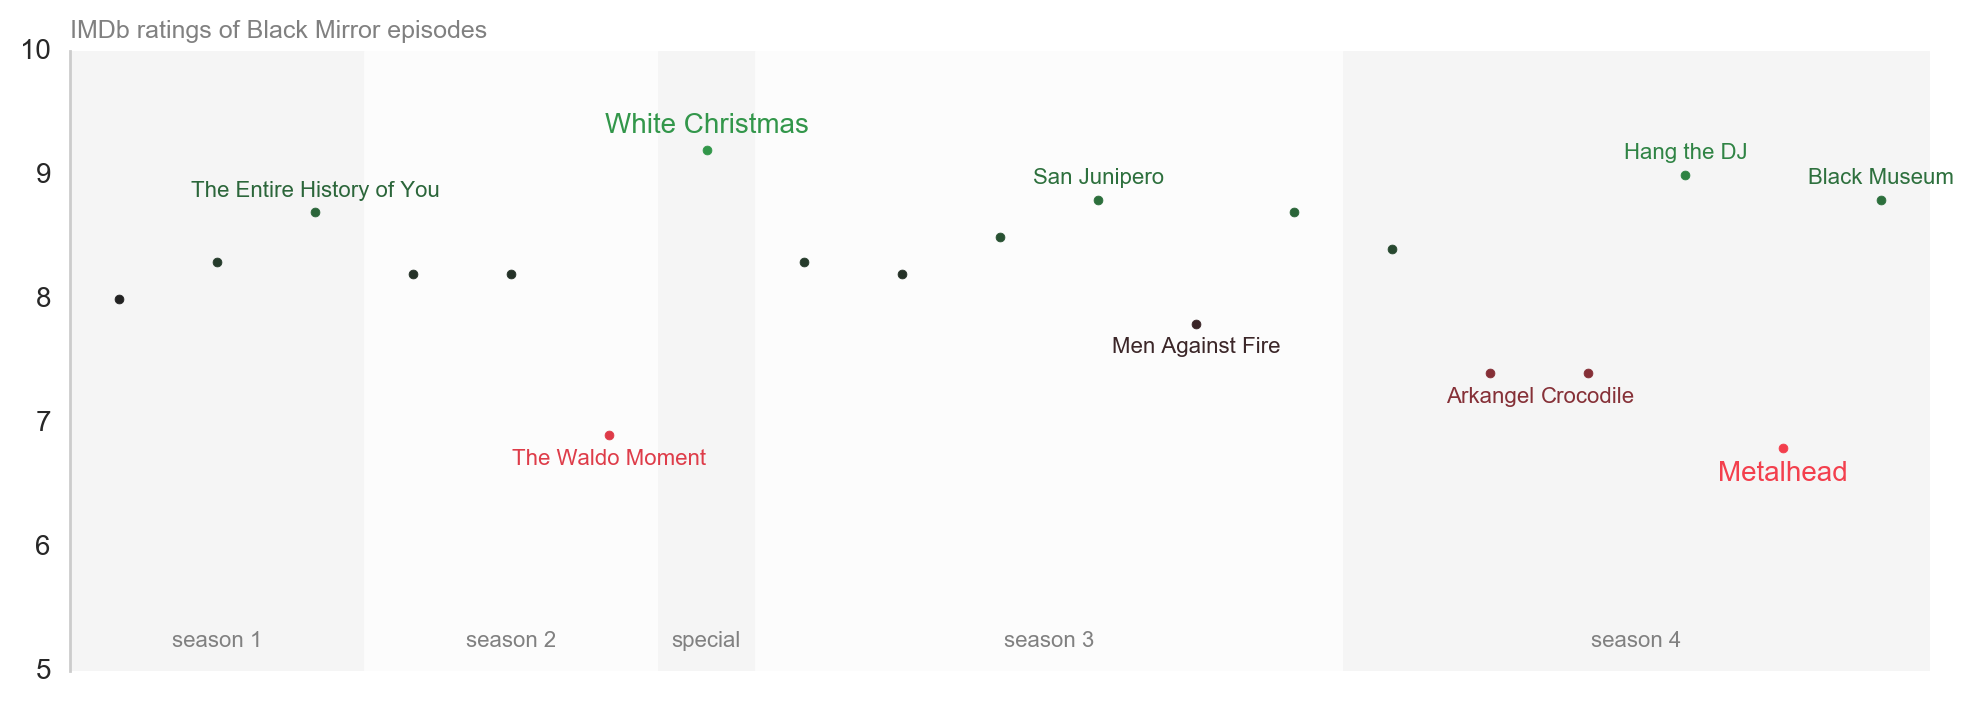

In [6]:
palette = sns.diverging_palette(133, 10, s=85, l=55, n=100, center="dark")
mx = episodes['imbd_rate'].max()
mn = episodes['imbd_rate'].min()
def get_color(val):
    return palette[int(99*(mx-val)/(mx-mn))]


plt.figure(figsize=(12, 4), dpi=200)

plt.fill_between([-0.5,2.5],[4,4],[10,10], color=(.96,.96,.96))
plt.fill_between([2.5,5.5],[4,4],[10,10], color=(.99,.99,.99))
plt.fill_between([5.5,6.5],[4,4],[10,10], color=(.96,.96,.96))
plt.fill_between([6.5,12.5],[4,4],[10,10], color=(.99,.99,.99))
plt.fill_between([12.5,18.5],[4,4],[10,10], color=(.96,.96,.96))
plt.text(1,5.2,'season 1',ha='center',color=(0.5,.5,.5), size=8)
plt.text(4,5.2,'season 2',ha='center',color=(0.5,.5,.5), size=8)
plt.text(6,5.2,'special',ha='center',color=(0.5,.5,.5), size=8)
plt.text(9.5,5.2,'season 3',ha='center',color=(0.5,.5,.5), size=8)
plt.text(15.5,5.2,'season 4',ha='center',color=(0.5,.5,.5), size=8)

for n, (idx, row) in enumerate(episodes.iterrows()):
    color = get_color(row['imbd_rate'])
    if row['imbd_rate']==mn:
        plt.text(n, row['imbd_rate']-0.1, row['name'],va='top', ha='center', color=color, size=10)
    elif row['imbd_rate']==mx:
        plt.text(n, row['imbd_rate']+0.1, row['name'],va='bottom', ha='center', color=color, size=10)
    elif idx in ('tt2386296','tt5710976','tt5709250','tt5709234'):
        plt.text(n, row['imbd_rate']-0.1, row['name'],va='top', ha='center', color=color, size=8)
    elif idx in ('tt5710978', 'tt5058700','tt4538072','tt2089050'):
        plt.text(n, row['imbd_rate']+0.1, row['name'],va='bottom', ha='center', color=color, size=8)

    plt.scatter(n, row['imbd_rate'], s=10, color=color)
        
#plt.text(idx, row['avg_mark'], '%.1f' % row['avg_mark'],ha='center',va='center')
plt.xticks([])
plt.yticks([5,6,7,8,9,10], size=10)
plt.ylim(ymin=5,ymax=10)
plt.xlim([-0.5,18.5])
sns.despine(bottom=True)
#plt.ylabel('IMBd rate')
plt.title('IMDb ratings of Black Mirror episodes', loc='left', color=(0.5,.5,.5), size=9)
plt.show()

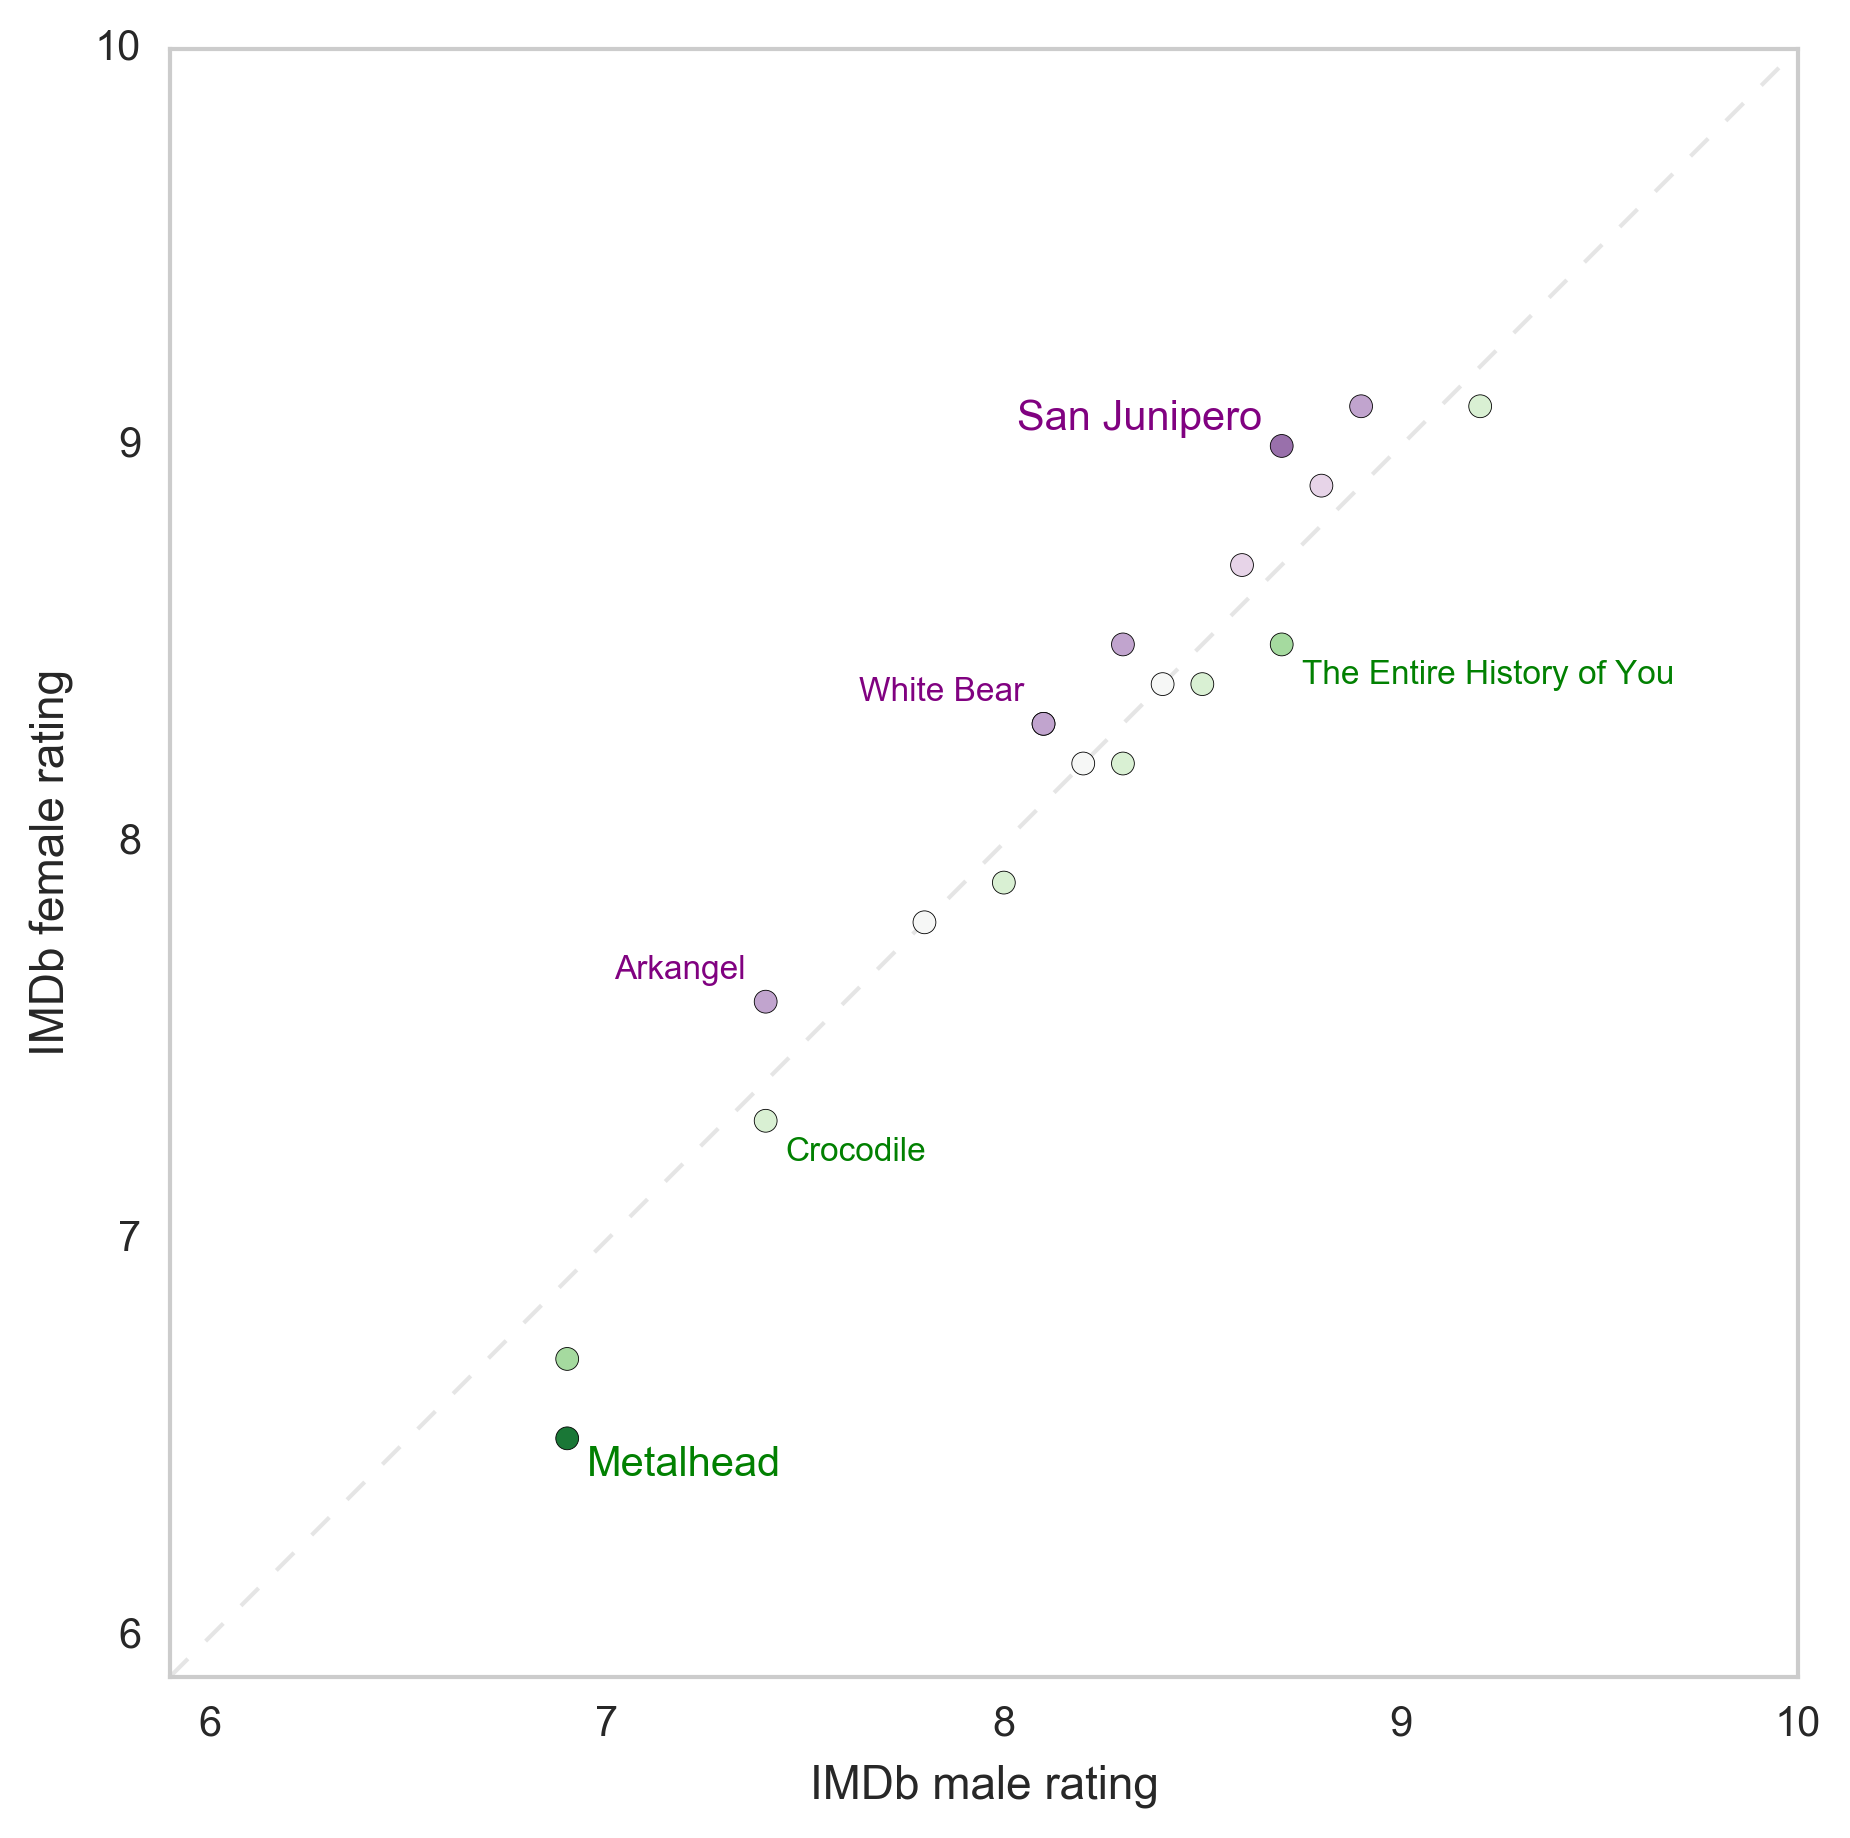

In [7]:
plt.figure(figsize=(7, 7), dpi=300)
plt.plot([5.9,10],[5.9,10],'black', linestyle='--', alpha=0.1,lw=1)
plt.scatter(episodes['imbd_male_rate'], episodes['imbd_female_rate'], 30,
            episodes['gender_gap'],  cmap='PRGn', vmin=-0.5, vmax=0.5, lw=0.2, zorder=100)
plt.xticks([6,7,8,9,10])
plt.yticks([6,7,8,9,10])
plt.xlim([5.9,10])
plt.ylim([5.9,10])
plt.xlabel('IMDb male rating')
plt.ylabel('IMDb female rating')
metalhead = episodes.loc['tt5710984']
plt.text(metalhead['imbd_male_rate']+0.05, metalhead['imbd_female_rate']-0.02, metalhead['name'], size=10,
            ha='left', color='green', va='top')
st_jun = episodes.loc['tt4538072']
plt.text(st_jun['imbd_male_rate']-0.05, st_jun['imbd_female_rate']+0.02, st_jun['name'], size=10,
            ha='right', color='purple', va='bottom')
hist_you = episodes.loc['tt2089050']
plt.text(hist_you['imbd_male_rate']+0.05, hist_you['imbd_female_rate']-0.04, hist_you['name'], size=8,
            ha='left', color='green', va='top')
croc = episodes.loc['tt5710976']
plt.text(croc['imbd_male_rate']+0.05, croc['imbd_female_rate']-0.04, croc['name'], size=8,
            ha='left', color='green', va='top')
ark = episodes.loc['tt5709250']
plt.text(ark['imbd_male_rate']-0.05, ark['imbd_female_rate']+0.04, ark['name'], size=8,
            ha='right', color='purple', va='bottom')
wht_bear = episodes.loc['tt2542420']
plt.text(wht_bear['imbd_male_rate']-0.05, wht_bear['imbd_female_rate']+0.04, wht_bear['name'], size=8,
            ha='right', color='purple', va='bottom')
plt.show()

In [8]:
imdb_codes = {}
imdb_codes['house of cards'] = ('tt1856010', 5)
imdb_codes['westworld'] = ('tt1856010', 1)
imdb_codes['stranger things'] = ('tt4574334', 2)
imdb_codes['true detective'] = ('tt2356777', 2)
imdb_codes['narcos'] = ('tt2707408', 3)
imdb_codes['dexter'] = ('tt0773262', 8)
imdb_codes['lost'] = ('tt0411008', 6)
imdb_codes['breaking bad'] = ('tt0903747', 5)
imdb_codes['game of thrones'] = ('tt0944947', 7)
imdb_codes['house'] = ('tt0412142', 8)
imdb_codes['sherlock'] = ('tt1475582', 4)
imdb_codes['fargo'] = ('tt2802850', 4)
imdb_codes['mad men'] = ('tt0804503', 7)
imdb_codes['vikings'] = ('tt2306299', 4)
imdb_codes['mr. robot'] = ('tt4158110', 3)

In [9]:
other_tv_shows_episodes = {}
for name, (code, n_seasons) in imdb_codes.items():
    print(name)
    show_eps = get_episodes(code, seasons=n_seasons)
    votes_info = []
    for eid in show_eps.index:
        votes_info.append(get_votes_info(eid))
    show_eps = show_eps.join(pd.DataFrame(votes_info).set_index('id'))
    show_eps['gender_gap'] = show_eps['imbd_male_rate']-show_eps['imbd_female_rate']
    print('%.1f\t%.1f <-> %.1f' % (show_eps['imbd_rate'].min(), show_eps['gender_gap'].min(), show_eps['gender_gap'].max()))
    print()
    other_tv_shows_episodes[name] = show_eps

game of thrones
8.1	-0.3 <-> 0.2

house
7.6	-0.6 <-> 0.6

breaking bad
7.6	-0.2 <-> 0.4

mr. robot
8.2	-0.3 <-> 1.3

westworld
7.9	-0.2 <-> 0.3

true detective
7.6	-0.2 <-> 0.5

house of cards
7.9	-0.5 <-> 0.6

lost
7.4	-0.7 <-> 0.0

dexter
4.8	-0.6 <-> 0.4

stranger things
6.2	-0.3 <-> 0.0

vikings
7.7	-0.5 <-> 0.2

mad men
7.6	0.1 <-> 0.8

narcos
8.0	-0.2 <-> 0.8

sherlock
7.7	-0.4 <-> 0.0

fargo
8.2	-0.4 <-> 0.8



In [10]:
cols = ['name','number', 'season', 'imbd_rate', 'imbd_female_rate', 'imbd_male_rate', 'gender_gap']
other_tv_shows_episodes['narcos'][cols].head(10)

,name,number,season,imbd_rate,imbd_female_rate,imbd_male_rate,gender_gap
id,,,,,,,
tt3591824,Descenso,1,1,8.9,8.7,9.0,0.3
tt3736868,The Sword of Simón Bolivar,2,1,8.6,8.0,8.6,0.6
tt3736866,The Men of Always,3,1,8.6,8.2,8.6,0.4
tt3736870,The Palace in Flames,4,1,8.8,8.2,8.8,0.6
tt3736874,There Will Be a Future,5,1,8.5,7.9,8.5,0.6
tt3736872,Explosivos,6,1,9.0,8.5,9.1,0.6
tt3736876,You Will Cry Tears of Blood,7,1,8.7,8.0,8.7,0.7
tt3736878,La Gran Mentira,8,1,8.9,8.3,9.0,0.7
tt3736882,La Catedral,9,1,8.7,8.0,8.8,0.8
